In [4]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

In [1]:
data_dir='./data/'
SEED=0
ADD_MU_SIGMA=False
SAVE_FIG=True

weights = np.array([2, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9])


def get_file_iter(data_dir):
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for filename in filenames:
            if filename.endswith('tsv'):
                yield(os.path.join(dirpath, filename))


def get_title(f):
    # remove dir
    name = os.path.basename(f)
    # remove extension
    name = os.path.splitext(name)[0]
    tokens = name.split('_')[1:]

    
    title = ""
    for index, t in enumerate(tokens):
        if (index == 0):
            title = t + " - "
        else:
            title = title + t + " "

    return title

def read_file(f):
    # read file
    df = pd.read_csv(f, sep='\t')
    
    # replace NAN with 0
    df = df.fillna(0)
    
    # discard first col (comment) and convert to numpy
    comments = df.iloc[:,0].values
    dataset = df.iloc[:, 1:].values

    return (comments, dataset)


def get_embedding(dataset):
    # perform embedding
    Z = TSNE(perplexity=5, random_state=SEED).fit_transform(dataset)
    return Z


def get_mean(dataset, keepdims=False):
    return np.sum(weights * dataset, axis=1, keepdims=keepdims) / 100.0


def get_std(dataset, keepdims=False):
    mu = get_mean(dataset, keepdims=True)
    err_squared = (mu - weights) ** 2
    weighted_err_squared = np.sum(err_squared * dataset, axis=1, keepdims=keepdims) / (100.0 - 1.0)

    return np.sqrt(weighted_err_squared)


def perform_t_sne(f):
    (comments, dataset) = read_file(f)
    Z = get_embedding(dataset)
    return (Z, comments, dataset)


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


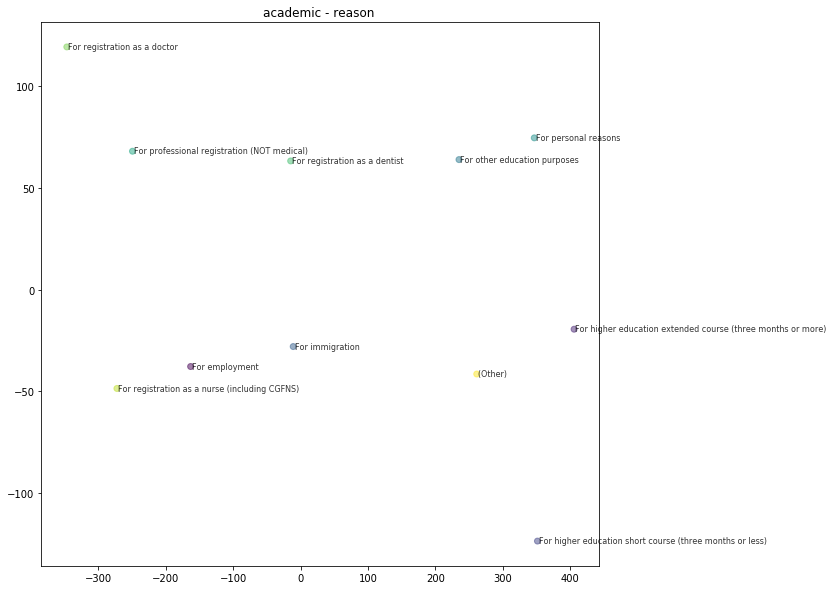

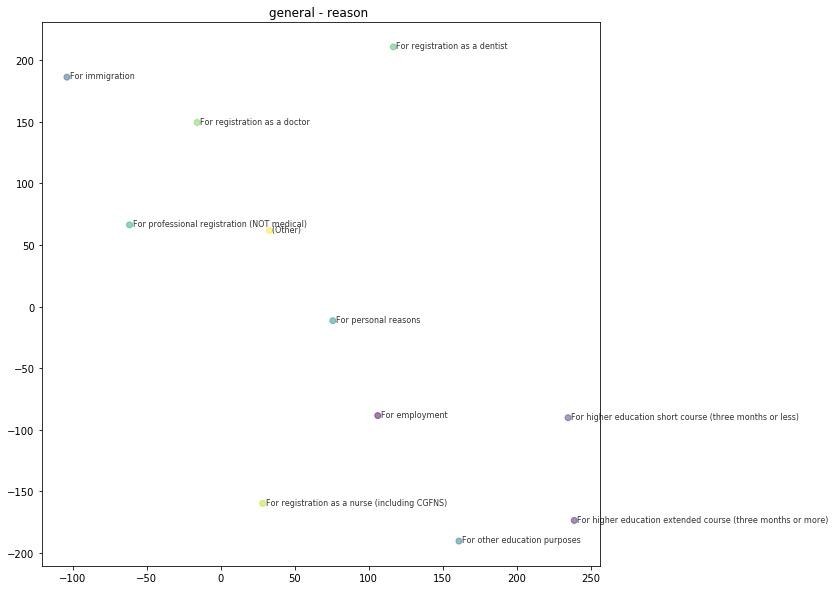

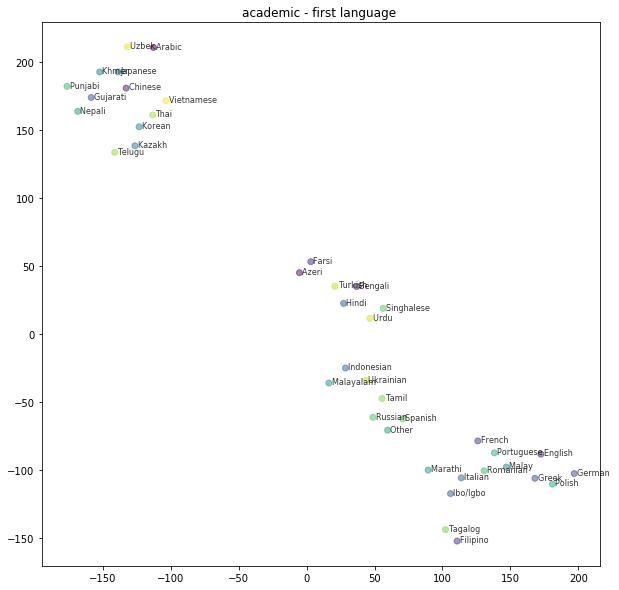

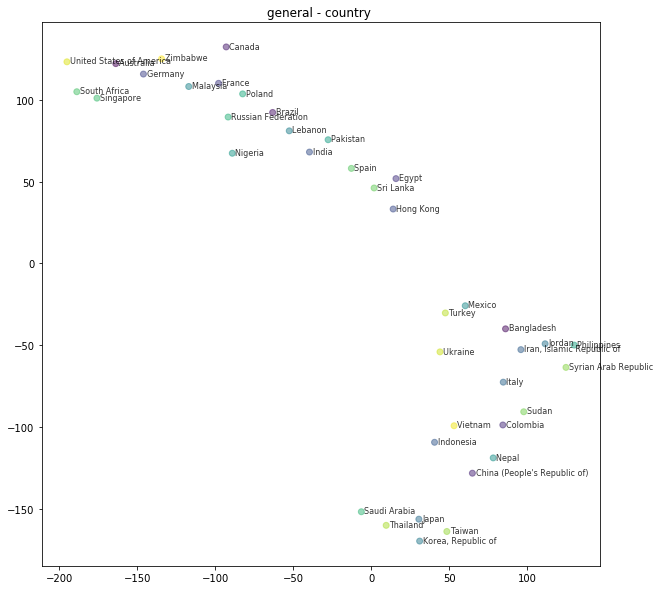

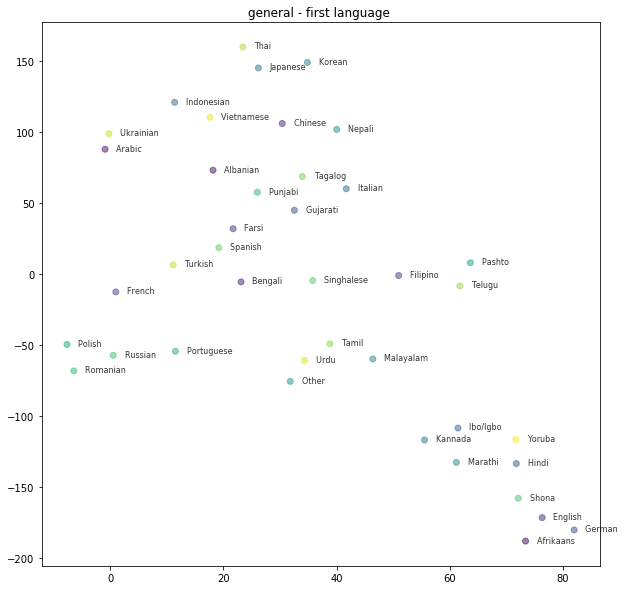

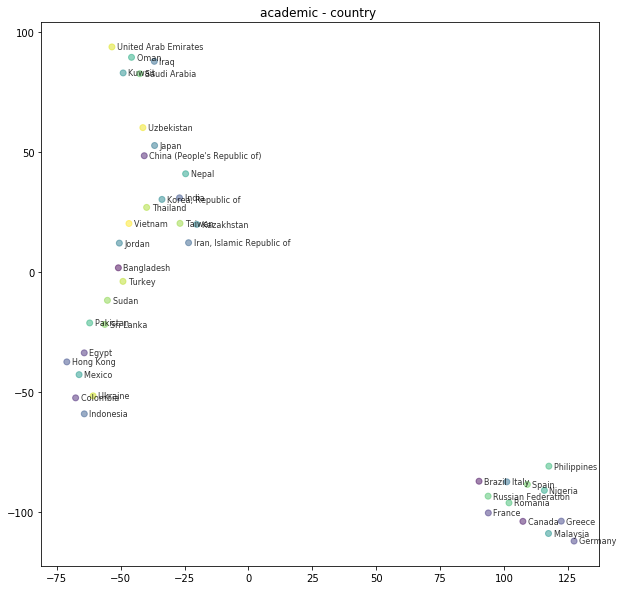

In [2]:
file_iter = get_file_iter(data_dir)
    

for index, f in enumerate(file_iter):
    Z, comments, dataset = perform_t_sne(f)

    mu = get_mean(dataset)
    std = get_std(dataset)

    title = get_title(f)

    fig = plt.figure(index, figsize=(10, 10))
    plt.scatter(Z[:,0], Z[:,1], c=np.arange(len(Z)), alpha=0.5)
    plt.title(title)

    for i, z in enumerate(Z):
        if ADD_MU_SIGMA == True:
            annot = "{}\n$\mu$:{:1.2f},$\sigma$:{:1.2f}".format(comments[i], mu[i], std[i])
        else:
            annot = "{}".format(comments[i])

        plt.annotate(annot, xy=z+[2.0, -1.0], alpha=0.8, fontsize=8.0)


    fig.show()

#     if SAVE_FIG == True:
#         fig_name = 'figures/fig-{}.png'.format(title)
#         fig.savefig(fig_name, dpi=320)

# Plot using Bokeh
Reference: https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization

In [5]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [23]:
filename = './data/ielts_academic_country.tsv'

data_pd = pd.read_csv(filename, sep='\t')

# replace NAN with 0
data_pd = data_pd.fillna(0)

In [24]:
data_pd.head()

,,Below 4,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9
0,Bangladesh,1.0,1.0,3,10,18,22,18,13,9,5,1,0.0
1,Brazil,0.0,1.0,1,4,9,17,21,20,16,9,2,0.0
2,Canada,0.0,0.0,1,3,7,15,19,21,17,12,5,0.0
3,China (People's Republic of),1.0,2.0,7,15,24,24,15,8,3,1,0,0.0
4,Colombia,0.0,1.0,2,6,13,22,22,17,12,5,1,0.0


In [36]:
countries = data_pd.iloc[:, 0].tolist()
print(len(countries))
countries[:5]

40


['Bangladesh ',
 'Brazil ',
 'Canada ',
 "China (People's Republic of) ",
 'Colombia ']

In [26]:
X = data_pd.iloc[:, 1:].values
X[:2]

array([[  1.,   1.,   3.,  10.,  18.,  22.,  18.,  13.,   9.,   5.,   1.,
          0.],
       [  0.,   1.,   1.,   4.,   9.,  17.,  21.,  20.,  16.,   9.,   2.,
          0.]])

In [49]:
tsne = TSNE(perplexity=5, n_components=2, random_state=SEED)
X_tsne = tsne.fit_transform(X)

print(len(X_tsne))

40


In [50]:
X_tsne[:2, :]

array([[-50.89762497,   1.64925981],
       [ 90.28091431, -87.18444824]], dtype=float32)

In [65]:
settings = dict(x=X_tsne[:, 0],
               y=X_tsne[:, 1],
               label=countries,
               title=countries,
               content=countries)

source = ColumnDataSource(settings)

labels = LabelSet(x='x', y='y', text='label', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas', text_font_size='6pt')

In [66]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source, alpha=0.8, size=10)#'msize', )

plot_lda.add_layout(labels)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)